In [1]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [2]:

import cv2
import math

import numpy as np
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import size
from matplotlib import colors
from asgiref.sync import sync_to_async #in order to load variables to communicate between sync and async
import numpy.linalg as LA

import optimal_path as op

from robot import Robot
from Map import Map
from Local_navigation import* 
from Mouvement import*
from vision import*
from optimal_path import* 


map_lenght = 1
nb_of_square_by_side = 50
current = 1

global move 
move = False #bool which indicate how our robot is moving (1: avoid an object VS 0: following the optimal path)
kalman_bool = False
old_distance = 0
old_angle = 0
ERR_POS = 3
speed_right = 0
speed_left = 0
#pourcentage_reduc = 1

In [3]:


#VideoCap = vision_initialization()
VideoCap=cv2.VideoCapture(1)


In [4]:
@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500, verbose=False):
    """
    Sets the motor speeds of the Thymio 
    param l_speed: left motor speed
    param r_speed: right motor speed
    param verbose: whether to print status messages or not
    """
    global motor_left_target, motor_right_target
    # Printing the speeds if requested
    if verbose:
        print("\t\t Setting speed : ", l_speed, r_speed)
    motor_left_target = l_speed
    motor_right_target = r_speed

In [5]:
@tdmclient.notebook.sync_var
def proxi():
    """
    Returns the proximity values of the Thymio 
    """
    global prox_horizontal
    return prox_horizontal


In [7]:
#############################
#Test MASK  A LANCER QUE POUR FAIRE DES TESTS SUR LE MASK
#############################

while True:
    ret, frame = VideoCap.read()
    mask, b = mask_map_init(frame)
    
    keyVal = cv2.waitKey(1) & 0xFF
    if keyVal == ord('q'):
        break
    cv2.imshow("mask",mask)
    cv2.imshow("mask B",b)
    #pos_robot, angle = update(frame, 0.5)


KeyboardInterrupt: 

In [6]:
George = Robot()
Lausanne = Map(map_lenght, nb_of_square_by_side)
KF = KalmanFilter(0.1,[0.0,0.0])
KF2 = KalmanFilter(0.1,[0.0,0.0])

taille frame (1080, 1920, 3)
MAP INITIALISATION
first while
searching for the strart pos
goal (59, 17)
start position (20, 42)
PATH COMPUTATION


True

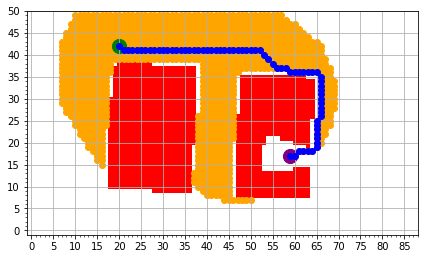

In [7]:
#np.set_printoptions(threshold=sys.maxsize)
####################################
## INIT
####################################
nb_frame_to_take = 10
# Prend une première image
for i in range (nb_frame_to_take): 
    ret, frame = VideoCap.read()
    
print("taille frame", frame.shape)
cv2.imwrite("debut.jpg", frame)

print("MAP INITIALISATION")
# Set the pourcentage value between the nb of pixel and nb of square by side
Lausanne.set_map_lenght(frame)
#print("Pourcentage",Lausanne.get_pourcentage())
# Set the robot goal, position and angle
goal = init_goal(frame, Lausanne.get_pourcentage())
#goal = (50, 40)

# Set pour relancer direct
pos_robot = (-1,-1)
George.set_pos(pos_robot) 
#print("GOAL", goal)

print("first while")
#pos_robot, angle = update(frame, Lausanne.get_pourcentage())  # fonction qui retourne la position angle etc....
 
      #Utiliser au cas où il ne trouve pas la bonne position du premier coup
while (pos_robot[0] <= 0) & (pos_robot[1] <= 0):
    #ret, frame=VideoCap.read()
    #display(frame,1,0,0)
    print("searching for the strart pos")
    ret, frame=VideoCap.read()
    #vs.display (frame, 0, 1, 1, 0, 5, Lausanne.get_pourcentage())
    pos_robot,pos_robot2, angle, bool_mesure = update(frame, Lausanne.get_pourcentage())  # fonction qui retourne la position angle etc....
    #print("Waiting robot position") 

George.set_angle(angle)
George.set_goal(goal)
George.set_start_pos(pos_robot)
George.set_pos(pos_robot)
print ("goal", goal)
print ("start position", pos_robot)

# SET MAP
Lausanne.set_map_lenght(frame)
#print("Lausanna lenght", Lausanne.get_lenght())

# MASK 
mask_bleu, mask_green = mask_map_init(frame)
#cv2.imshow("mask", mask)
cv2.imwrite("masque1.jpg", mask_bleu)
cv2.imwrite("masque2.jpg", mask_green)

# Fin de l'init
Lausanne.init_grid(mask_bleu,mask_green)
grille = Lausanne.get_map()
#cv2.imshow("grid", grille)
cv2.imwrite("grille.jpg", grille)

# OPTIMAL PATH
print("PATH COMPUTATION")
path, visitedNodes = op.path_computation(George.get_start() , George.get_goal() , Lausanne.get_lenght(), grille)

George.set_path(path) 
George.set_visit_nodes(visitedNodes) 

# Display the optimal path
op.display_map(Lausanne.get_lenght(),  grille,  George.get_visit_nodes(), George.get_path(), George.get_start(), George.get_goal())
#print("PATH", George.get_path())

display (frame, 0, 1, 1, 1, George.get_path(), Lausanne.get_pourcentage())
#print("PATH22222", George.get_path())
cv2.imwrite("TOTAL.jpg", frame)

#vision_end(VideoCap)



In [8]:

####################################
## while
####################################

George.set_current(0)
current= 0
kalman_bool = False
print("PATH", George.get_path())
old_distance = 0
old_angle = 0
soon_arrived = False
thresh_indentation = 15
print('START MOUVEMENT')
while True:#(George.get_pos() != George.get_goal()):
    
    # Read the camera
    ret, frame=VideoCap.read(1)
    
    # Recupere la position et angle --> XAV
    pos_robot, pos_robot2, angle_robot, bool_mesure = update(frame, Lausanne.get_pourcentage())
    print("pos avant kalman", pos_robot)
    print("Pos avant 2", pos_robot2)
    print("angle avant kalman", angle_robot)
    pos = KF.kalmanFilter(bool_mesure, speed_left, speed_right, pos_robot, angle_robot)
    pos2 = KF2.kalmanFilter(bool_mesure, speed_left, speed_right, pos_robot2, angle_robot)
    x = pos2[0]-pos[0]
    y = pos2[1]-pos[1]
    print ("X", x)
    print ("Y", y)
    angle_robot2 = KF.angle_of_vectors_2(x, y, 1, 0)
    print("pos après kalman", pos_robot)
    print("pos2", pos2)
    print("angle après kalman", angle_robot2)
    George.set_pos(pos)
    George.set_angle(angle_robot2)
    
    if(current < George.get_path().shape[1]-1):
        current = path_update(pos, ERR_POS, np.transpose(George.get_path())[current], George.get_current())#
        George.set_current(current)
    else:
        print("READY TO PARK")
        motors(0,0)
        break
    
    pos_goal =  np.transpose(George.get_path())[current]
    
    if current > (George.get_path().shape[1] - thresh_indentation) :
        soon_arrived = True
        print('soon arrived')
    
    proximity = proxi()
    
    move = False
        #LOCAL NAVIGATION
    if move and not (soon_arrived):
        #Thymio is avoiding obstacles
        print("OBSTACLLLEEEE")
        speed_l, speed_r, move = avoid_obstacle(prox_horizonta=proximity) 
    else:
        #Thymio is following the optimal path
        speed_l, speed_r, old_distance, old_goal  = move_to_position( pos, angle_robot2, pos_goal, old_distance, old_angle)#
        #Thymio is checking if there's an obstacle in front of it
        move = check_cars(prox_horizonta=proximity)
       
    
    speed_right =  speed_r
    speed_left = speed_l
    motors(speed_l, speed_r) 
    
    display (frame, 0, 1, 1, 1, path, Lausanne.get_pourcentage())
    
    # Quit when we press q
    keyVal = cv2.waitKey(1) & 0xFF
    if keyVal == ord('q'):
        motors(0,0)
        break
     
    sleep(0.1)

print("PARKING")


"""
proximity = proxi()

while proxis[2] > parking_treshold

    speed0 = 70
    err_angle = proxis[1]-proxis[3]
    err_dist = proxis[2]
    
    speed_l = speed0 + Kp*err_dist + Kp*err_angle
    speed _r = speed0 + Kp*err_dist - Kp*err_angle
    if(err_dist < min_err_dist)
        motors(0,0)
        print("ARRIVED")
        break
    motors(speed_l, speed_r)
    proximity = proxi()
    
"""
    

PATH [[20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
  44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 66
  66 66 66 66 66 66 66 66 65 65 65 65 65 65 65 64 63 62 61 60 59]
 [42 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
  41 41 41 41 41 41 41 41 41 40 39 38 37 37 37 36 36 36 36 36 36 36 35 34
  33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 18 18 18 17 17]]
START MOUVEMENT
pos avant kalman (21, 42)
Pos avant 2 (27, 41)
angle avant kalman -0.17123873610543722
MESURE
MESURE
X 0.0
Y 0.0
pos après kalman (21, 42)
pos2 [0. 0.]
angle après kalman 0
1.1263771168937977
pos avant kalman (21, 42)
Pos avant 2 (27, 41)
angle avant kalman -0.15660187698201544
MESURE
MESURE
X 4.0
Y -1.0
pos après kalman (21, 42)
pos2 [18. 27.]
angle après kalman -0.24497866312686423
1.4108832036366774
pos avant kalman (21, 42)
Pos avant 2 (27, 42)
angle avant kalman -0.05219136558710616
MESURE
MESURE
X 6.0
Y -1.0
pos après kalman (21, 42)
pos2

pos avant kalman (29, 41)
Pos avant 2 (36, 41)
angle avant kalman -0.030066125049042727
X 7.000000000000011
Y 0.0
pos après kalman (29, 41)
pos2 [36.6 41. ]
angle après kalman 0.0
0.0
pos avant kalman (29, 41)
Pos avant 2 (36, 41)
angle avant kalman -0.030066125049042727
X 7.000000000000014
Y 0.0
pos après kalman (29, 41)
pos2 [36.8 41. ]
angle après kalman 0.0
0.0
pos avant kalman (29, 41)
Pos avant 2 (36, 41)
angle avant kalman -0.030066125049042727
X 7.000000000000018
Y 0.0
pos après kalman (29, 41)
pos2 [37. 41.]
angle après kalman 0.0
0.0
pos avant kalman (29, 41)
Pos avant 2 (36, 41)
angle avant kalman -0.030066125049042727
X 7.000000000000021
Y 0.0
pos après kalman (29, 41)
pos2 [37.2 41. ]
angle après kalman 0.0
next goal plz
0.0
pos avant kalman (29, 41)
Pos avant 2 (36, 41)
angle avant kalman -0.030066125049042727
X 7.000000000000025
Y 0.0
pos après kalman (29, 41)
pos2 [37.4 41. ]
angle après kalman 0.0
0.0
pos avant kalman (29, 41)
Pos avant 2 (36, 41)
angle avant kalman -0

pos avant kalman (43, 42)
Pos avant 2 (49, 43)
angle avant kalman 0.14966604368960917
MESURE
MESURE
X 6.0
Y 1.0
pos après kalman (43, 42)
pos2 [49.2 43.1]
angle après kalman 0.16514867741462674
5.836264762491607
pos avant kalman (44, 42)
Pos avant 2 (50, 42)
angle avant kalman 0.02343320987946826
MESURE
MESURE
X 6.0
Y 1.0
pos après kalman (44, 42)
pos2 [49.2 43. ]
angle après kalman 0.16514867741462674
5.86071291479387
pos avant kalman (44, 42)
Pos avant 2 (50, 41)
angle avant kalman -0.08506553996864465
MESURE
MESURE
X 6.0
Y 0.0
pos après kalman (44, 42)
pos2 [50.2 42. ]
angle après kalman 0.0
next goal plz
6.025861592208497
pos avant kalman (44, 42)
Pos avant 2 (50, 41)
angle avant kalman -0.1867738045427187
MESURE
MESURE
X 6.0
Y -1.0
pos après kalman (44, 42)
pos2 [50.2 41. ]
angle après kalman -0.16514867741462674
6.191010269623124
pos avant kalman (45, 42)
Pos avant 2 (50, 40)
angle avant kalman -0.2581111163831621
MESURE
MESURE
X 6.0
Y -1.0
pos après kalman (45, 42)
pos2 [50.2 41

pos avant kalman (53, 40)
Pos avant 2 (57, 36)
angle avant kalman -0.6846171643127805
X 4.0
Y -4.0
pos après kalman (53, 40)
pos2 [58.8 35.1]
angle après kalman -0.7853981633974484
6.487827117009363
pos avant kalman (53, 40)
Pos avant 2 (57, 36)
angle avant kalman -0.6846171643127805
X 4.0
Y -4.0
pos après kalman (53, 40)
pos2 [59. 35.]
angle après kalman -0.7853981633974484
next goal plz
6.4250823617837485
pos avant kalman (53, 40)
Pos avant 2 (57, 36)
angle avant kalman -0.6846171643127805
X 4.0
Y -4.0
pos après kalman (53, 40)
pos2 [59.2 34.9]
angle après kalman -0.7853981633974484
6.416714356271456
pos avant kalman (53, 40)
Pos avant 2 (57, 36)
angle avant kalman -0.6846171643127805
X 4.0
Y -4.0
pos après kalman (53, 40)
pos2 [59.4 34.8]
angle après kalman -0.7853981633974484
6.407540301726346
pos avant kalman (53, 40)
Pos avant 2 (57, 36)
angle avant kalman -0.6846171643127805
X 4.0
Y -4.0
pos après kalman (53, 40)
pos2 [59.6 34.7]
angle après kalman -0.7853981633974484
6.39743963

pos avant kalman (65, 34)
Pos avant 2 (67, 28)
angle avant kalman -1.3296786483434282
MESURE
MESURE
X 2.0
Y -5.9999999999999964
pos après kalman (65, 34)
pos2 [67.1 27.8]
angle après kalman -1.2490457723982542
6.193991694587854
pos avant kalman (66, 33)
Pos avant 2 (67, 28)
angle avant kalman -1.3624807642054706
MESURE
MESURE
X 2.0
Y -5.9999999999999964
pos après kalman (66, 33)
pos2 [67.1 27.8]
angle après kalman -1.2490457723982542
6.193991694587854
pos avant kalman (66, 33)
Pos avant 2 (67, 27)
angle avant kalman -1.379611867197882
MESURE
MESURE
X 1.0
Y -4.9999999999999964
pos après kalman (66, 33)
pos2 [67.  27.8]
angle après kalman -1.3734007669450157
next goal plz
6.085789747329706
pos avant kalman (66, 33)
Pos avant 2 (67, 27)
angle avant kalman -1.412141064608495
MESURE
MESURE
X 1.0
Y -5.9999999999999964
pos après kalman (66, 33)
pos2 [67.  26.8]
angle après kalman -1.4056476493802696
6.118036629764959
pos avant kalman (66, 32)
Pos avant 2 (66, 27)
angle avant kalman -1.4583691

6.448333984594213
pos avant kalman (65, 22)
Pos avant 2 (65, 16)
angle avant kalman -1.68836190093254
MESURE
MESURE
X -1.0
Y -5.0
pos après kalman (65, 22)
pos2 [64.  16.8]
angle après kalman -1.7681918866447774
next goal plz
soon arrived
6.223257152058379
pos avant kalman (65, 22)
Pos avant 2 (65, 16)
angle avant kalman -1.6565232025656413
MESURE
MESURE
X 0.0
Y -6.0
pos après kalman (65, 22)
pos2 [65.  15.8]
angle après kalman -1.5707963267948966
soon arrived
6.025861592208498
pos avant kalman (65, 21)
Pos avant 2 (65, 16)
angle avant kalman -1.6558618667635414
MESURE
MESURE
X 0.0
Y -6.0
pos après kalman (65, 21)
pos2 [65.  15.8]
angle après kalman -1.5707963267948966
soon arrived
6.025861592208498
pos avant kalman (65, 21)
Pos avant 2 (64, 15)
angle avant kalman -1.7028360884095353
MESURE
MESURE
X 0.0
Y -5.0
pos après kalman (65, 21)
pos2 [65.  15.8]
angle après kalman -1.5707963267948966
next goal plz
soon arrived
5.662935821196765
pos avant kalman (65, 21)
Pos avant 2 (64, 15)
angl

'\nproximity = proxi()\n\nwhile proxis[2] > parking_treshold\n\n    speed0 = 70\n    err_angle = proxis[1]-proxis[3]\n    err_dist = proxis[2]\n    \n    speed_l = speed0 + Kp*err_dist + Kp*err_angle\n    speed _r = speed0 + Kp*err_dist - Kp*err_angle\n    if(err_dist < min_err_dist)\n        motors(0,0)\n        print("ARRIVED")\n        break\n    motors(speed_l, speed_r)\n    proximity = proxi()\n    \n'

In [9]:
vision_end(VideoCap)

In [9]:
motors(0,0)